In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

## 1. Load Data

In [26]:
# Find the latest experiment directory
exp_dir = './experiments'
subdirs = [d for d in os.listdir(exp_dir) if d.startswith('beta_stats_1.3B')]
latest_subdir = sorted(subdirs)[-1]
output_dir = os.path.join(exp_dir, latest_subdir)

# Manually set experiment dir if needed
# subdir = 'beta_stats_1.3B_01081149'
# output_dir = os.path.join(exp_dir, subdir)

print(f"Loading data from: {output_dir}")

# List all files
files = [f for f in os.listdir(output_dir) if f.endswith('.pt')]
print(f"Found {len(files)} files")
print(f"Files: {files[:5]}..." if len(files) > 5 else f"Files: {files}")

Loading data from: ./experiments/beta_stats_1.3B_01081153_beta_flat_reduced.png_beta_var_heatmaps.png


NotADirectoryError: [Errno 20] Not a directory: './experiments/beta_stats_1.3B_01081153_beta_flat_reduced.png_beta_var_heatmaps.png'

In [ ]:
# Load first file to inspect
first_file = os.path.join(output_dir, files[0])
data = torch.load(first_file)

print("Data structure:")
for key, value in data.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: {list(value.shape)} ({value.dtype})")
    else:
        print(f"  {key}: {value}")

Data structure:
  doc2_id: 5a71242d5542994082a3e5cc
  doc2_text: {'title': 'Guy Waters', 'content': 'Guy "Arc Angel" Waters ( (1964--) 25 1964 (age (2017)-(1964)-((11)<(01)or(11)==(01)and(30)<(25)) ) ) is an Australian professional welter/light middle/middle/super middle/light heavy/cruiserweight boxer of the 1980s, 1990s and 2000s who won the New South Wales State (Australia) light heavyweight title, Australian light heavyweight title, Oriental and Pacific Boxing Federation (OPBF) light heavyweight title, Australasian Light Heavyweight Title, World Boxing Federation (WBF) light heavyweight title, International Boxing Federation (IBF) Pan Pacific super middleweight title, Oriental and Pacific Boxing Federation (OPBF) super middleweight title, and Commonwealth light heavyweight title, and was a challenger for the WBC light heavyweight title against Dennis Andries, World Boxing Association (WBA) World light heavyweight title against Virgil Hill, World Boxing Council (WBC) cruiserweight t

## 2. Visualize Beta Mean - Heatmaps

Visualize how beta state propagation weights vary across layers, heads, and state dimensions.

Beta shape: `[n_layer, nheads, headdim, d_state]`

In [ ]:
beta_mean = data['beta_mean']  # [n_layer, nheads, headdim, d_state]
beta_var = data['beta_var']

n_layer, nheads, headdim, d_state = beta_mean.shape
print(f"Shape: [layers={n_layer}, heads={nheads}, headdim={headdim}, d_state={d_state}]")

Shape: [layers=48, heads=64, headdim=64, d_state=128]


In [ ]:
# Average across head dimensions to get [n_layer, nheads, d_state]
beta_mean_avg = beta_mean.mean(dim=2).numpy()  # [n_layer, nheads, d_state]

# Use all heads instead of random selection
all_heads = list(range(nheads))
print(f"Visualizing all {nheads} heads")

Visualizing all 64 heads


Beta flat shape: torch.Size([48, 4096, 128])
Beta flat mean shape: (48, 128)
Beta flat RMS shape: (48, 128)


/root/autodl-tmp/tmp/ipykernel_191849/3932554175.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: ./experiments/beta_stats_1.3B_01081153_beta_flat_reduced.png


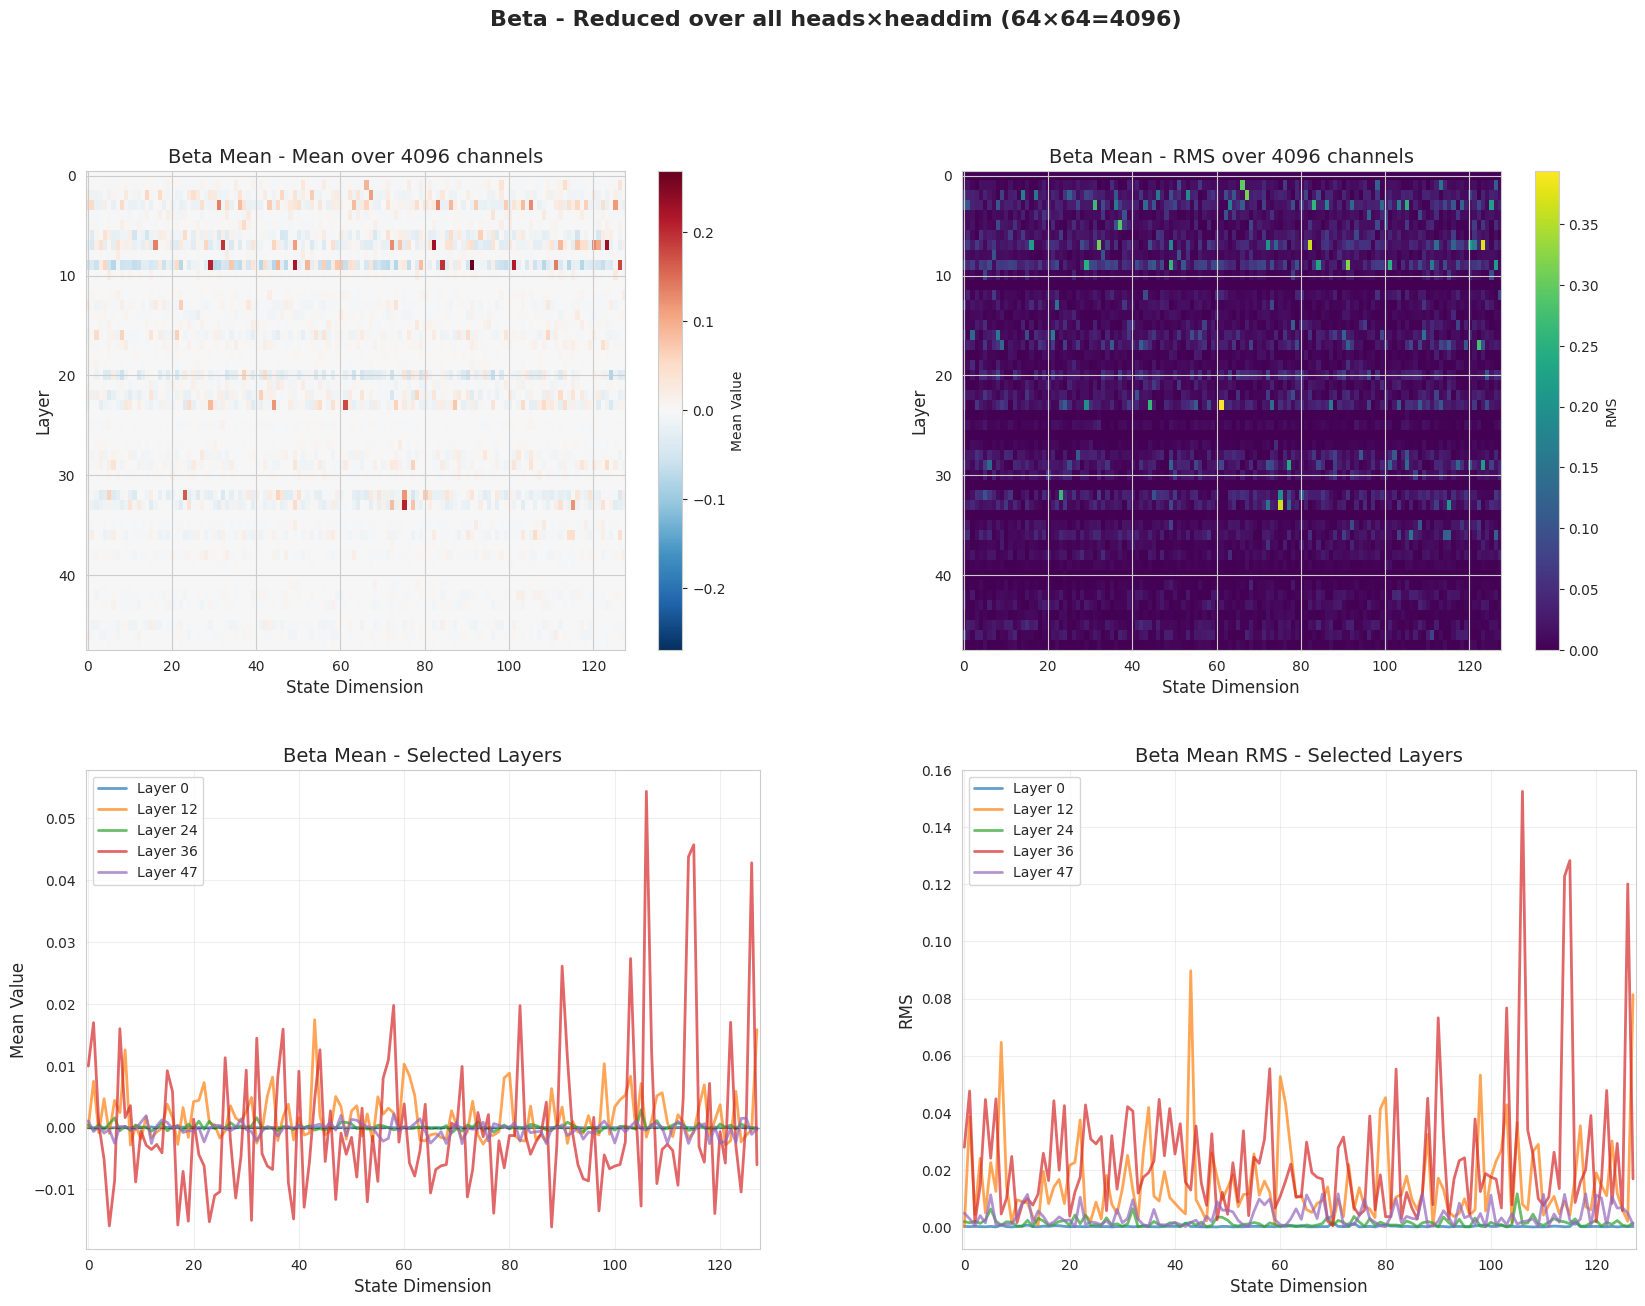

In [ ]:
# Flatten last two dimensions (nheads * headdim) and reduce
# beta_mean: [n_layer, nheads, headdim, d_state] -> [n_layer, nheads*headdim, d_state]
beta_flat = beta_mean.reshape(n_layer, -1, d_state)  # [n_layer, nheads*headdim, d_state]

# Calculate mean and RMS over the flattened dimension
beta_flat_mean = beta_flat.mean(dim=1).cpu().numpy()  # [n_layer, d_state]
beta_flat_rms = torch.sqrt((beta_flat ** 2).mean(dim=1)).cpu().numpy()  # [n_layer, d_state]

print(f"Beta flat shape: {beta_flat.shape}")
print(f"Beta flat mean shape: {beta_flat_mean.shape}")
print(f"Beta flat RMS shape: {beta_flat_rms.shape}")

# Select some layers for line plots
selected_layers = [0, n_layer//4, n_layer//2, 3*n_layer//4, n_layer-1]

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14),
                         gridspec_kw={'hspace': 0.25, 'wspace': 0.3})

# Share x-axis between rows
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 1])

# Add main title
fig.suptitle(f"Beta - Reduced over all heads×headdim ({nheads}×{headdim}={nheads*headdim})", 
             fontsize=16, fontweight='bold', y=0.995)

# Top Left: Mean Heatmap
vmax_mean = max(abs(beta_flat_mean.min()), abs(beta_flat_mean.max()))
im1 = axes[0, 0].imshow(beta_flat_mean, aspect='auto', cmap='RdBu_r', 
                        interpolation='nearest', vmin=-vmax_mean, vmax=vmax_mean)
axes[0, 0].set_ylabel('Layer', fontsize=12)
axes[0, 0].set_xlabel('State Dimension', fontsize=12)
axes[0, 0].set_title(f'Beta Mean - Mean over {nheads*headdim} channels', fontsize=14)
plt.colorbar(im1, ax=axes[0, 0], label='Mean Value')

# Top Right: RMS Heatmap
im2 = axes[0, 1].imshow(beta_flat_rms, aspect='auto', cmap='viridis', interpolation='nearest')
axes[0, 1].set_ylabel('Layer', fontsize=12)
axes[0, 1].set_xlabel('State Dimension', fontsize=12)
axes[0, 1].set_title(f'Beta Mean - RMS over {nheads*headdim} channels', fontsize=14)
plt.colorbar(im2, ax=axes[0, 1], label='RMS')

# Bottom Left: Line plot for Mean
for layer in selected_layers:
    axes[1, 0].plot(beta_flat_mean[layer], label=f'Layer {layer}', alpha=0.7, linewidth=2)
axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[1, 0].set_xlabel('State Dimension', fontsize=12)
axes[1, 0].set_ylabel('Mean Value', fontsize=12)
axes[1, 0].set_title('Beta Mean - Selected Layers', fontsize=14)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Bottom Right: Line plot for RMS
for layer in selected_layers:
    axes[1, 1].plot(beta_flat_rms[layer], label=f'Layer {layer}', alpha=0.7, linewidth=2)
axes[1, 1].set_xlabel('State Dimension', fontsize=12)
axes[1, 1].set_ylabel('RMS', fontsize=12)
axes[1, 1].set_title('Beta Mean RMS - Selected Layers', fontsize=14)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}_beta_flat_reduced.png', dpi=150, bbox_inches='tight')
print(f"Saved: {output_dir}_beta_flat_reduced.png")
plt.show()

Beta heatmap mean shape: (48, 4096)
Beta heatmap RMS shape: (48, 4096)
Mean range: [-0.036984, 0.182626]
RMS range: [0.000000, 0.385280]


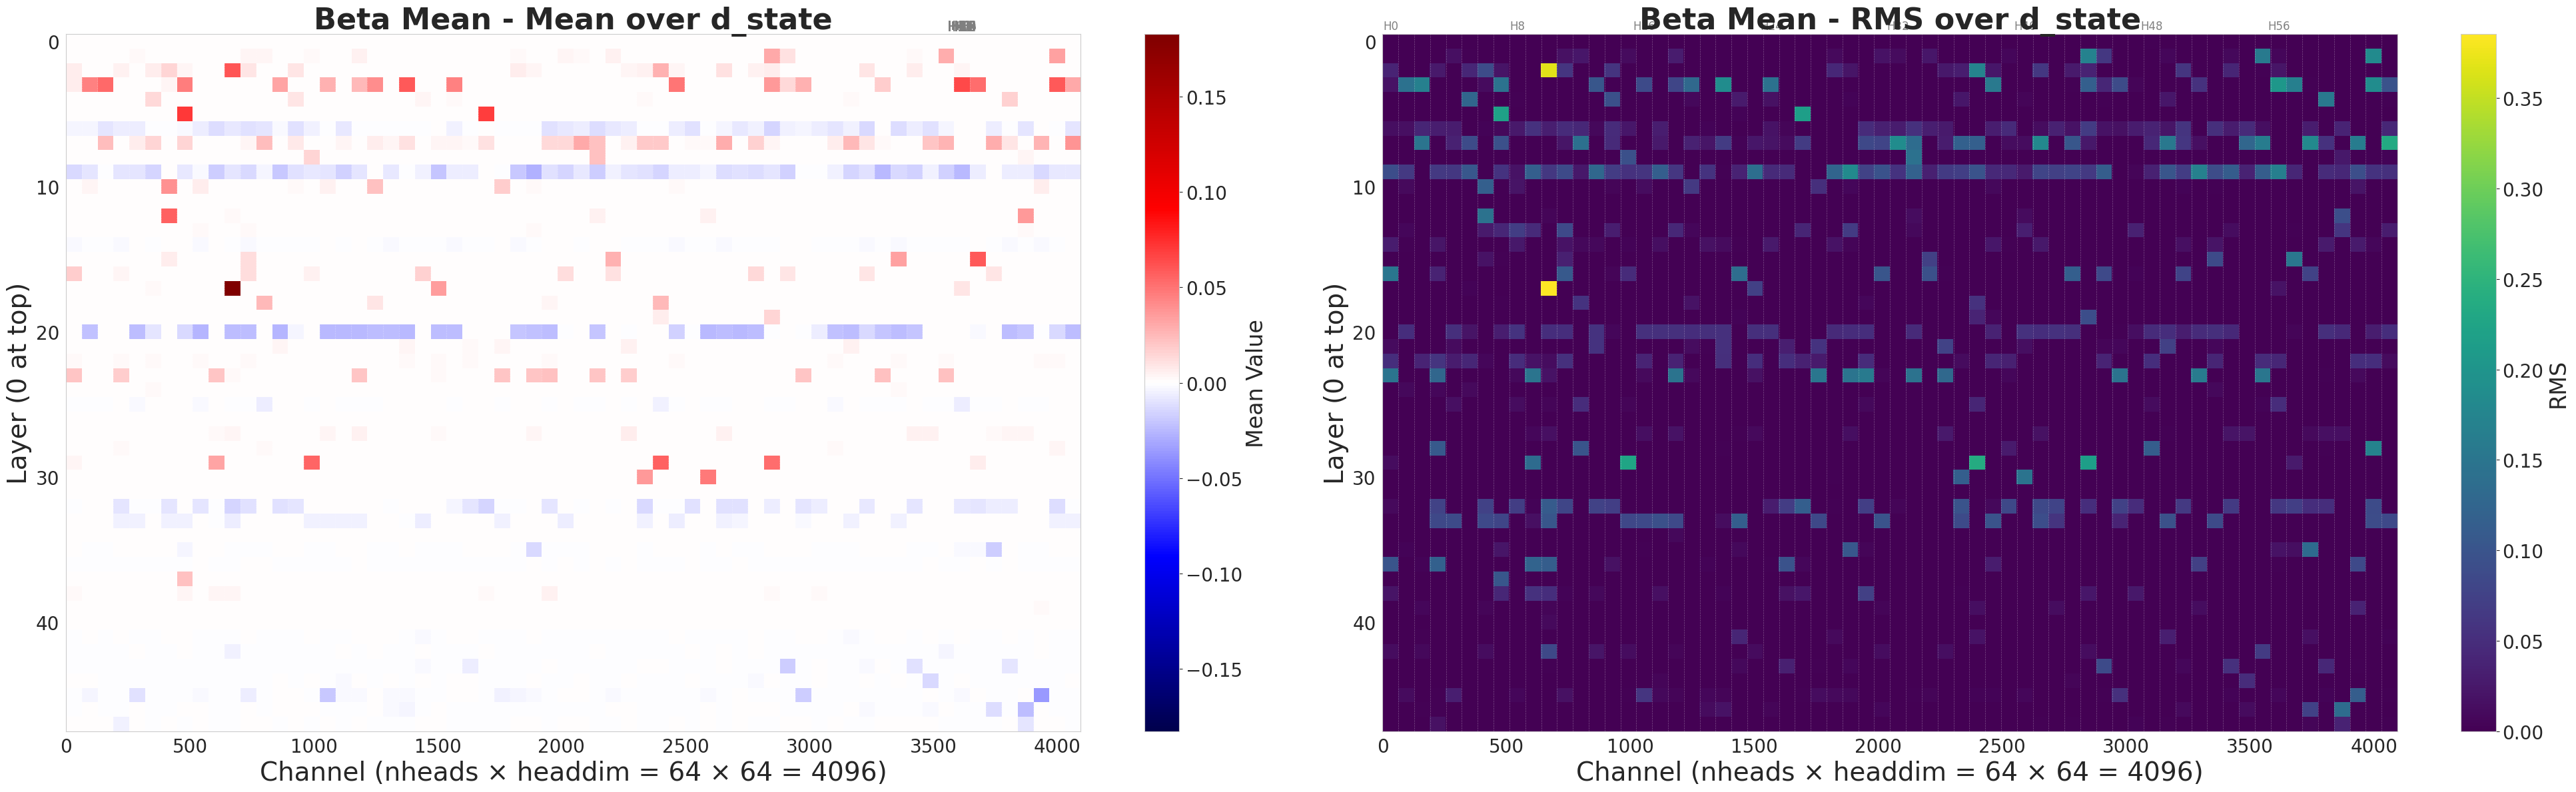

In [28]:
# Heatmap: reduce d_state dimension, 展开 nheads × headdim
# beta_mean: [n_layer, nheads, headdim, d_state]

# Left: Mean over d_state -> [n_layer, nheads, headdim]
beta_mean_reduced_state = beta_mean.mean(dim=3).cpu().numpy()
beta_heatmap_mean = beta_mean_reduced_state.reshape(n_layer, -1)  # [n_layer, nheads*headdim]

# Right: RMS over d_state -> [n_layer, nheads, headdim]
beta_rms_reduced_state = torch.sqrt((beta_mean ** 2).mean(dim=3)).cpu().numpy()
beta_heatmap_rms = beta_rms_reduced_state.reshape(n_layer, -1)  # [n_layer, nheads*headdim]

print(f"Beta heatmap mean shape: {beta_heatmap_mean.shape}")
print(f"Beta heatmap RMS shape: {beta_heatmap_rms.shape}")
print(f"Mean range: [{beta_heatmap_mean.min():.6f}, {beta_heatmap_mean.max():.6f}]")
print(f"RMS range: [{beta_heatmap_rms.min():.6f}, {beta_heatmap_rms.max():.6f}]")

# Create figure with 1x2 subplots
from matplotlib.colors import TwoSlopeNorm

fig, axes = plt.subplots(1, 2, figsize=(40, 12))

# Left: Mean heatmap
vmax_mean_hm = max(abs(beta_heatmap_mean.min()), abs(beta_heatmap_mean.max()))
vmin_mean_hm = -vmax_mean_hm
norm_mean = TwoSlopeNorm(vmin=vmin_mean_hm, vcenter=0, vmax=vmax_mean_hm)

im1 = axes[0].imshow(beta_heatmap_mean, aspect='auto', cmap='seismic', 
                     interpolation='nearest', norm=norm_mean)

axes[0].set_xlabel(f'Channel (nheads × headdim = {nheads} × {headdim} = {nheads*headdim})', fontsize=28)
axes[0].set_ylabel('Layer (0 at top)', fontsize=28)
axes[0].set_title('Beta Mean - Mean over d_state', fontsize=32, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=20)
axes[0].grid(False)

cbar1 = plt.colorbar(im1, ax=axes[0], label='Mean Value')
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label('Mean Value', fontsize=24)

# Add vertical lines to separate heads
for head_idx in range(1, nheads):
    axes[0].axvline(x=head_idx * headdim - 0.5, color='white', linestyle='--', alpha=0.3, linewidth=0.5)

# Add text annotation for head boundaries
head_stride = max(1, nheads // 8)
for head_idx in range(0, nheads, head_stride):
    axes[0].text(x_pos, -1.5, f'H{head_idx}', ha='center', va='top', fontsize=16, color='gray')
    axes[0].text(x_pos, -1.5, f'H{head_idx}', ha='center', va='top', fontsize=12, color='gray')

# Right: RMS heatmap
vmin_rms_hm = beta_heatmap_rms.min()
vmax_rms_hm = beta_heatmap_rms.max()

im2 = axes[1].imshow(beta_heatmap_rms, aspect='auto', cmap='viridis', 
                     interpolation='nearest', vmin=vmin_rms_hm, vmax=vmax_rms_hm)
axes[1].set_xlabel(f'Channel (nheads × headdim = {nheads} × {headdim} = {nheads*headdim})', fontsize=28)
axes[1].set_ylabel('Layer (0 at top)', fontsize=28)
axes[1].set_title('Beta Mean - RMS over d_state', fontsize=32, fontweight='bold')
axes[1].tick_params(axis='both', labelsize=20)
axes[1].grid(False)

cbar2 = plt.colorbar(im2, ax=axes[1], label='RMS')
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label('RMS', fontsize=24)

# Add vertical lines to separate heads
for head_idx in range(1, nheads):
    axes[1].axvline(x=head_idx * headdim - 0.5, color='white', linestyle='--', alpha=0.3, linewidth=0.5)

# Add text annotation for head boundaries
for head_idx in range(0, nheads, head_stride):
    x_pos = head_idx * headdim + headdim // 2
    axes[1].text(x_pos, -1.5, f'H{head_idx}', ha='center', va='top', fontsize=12, color='gray')




plt.tight_layout()
plt.show()

## 3. Visualize Beta Variance - Heatmaps

Visualize how variance varies across layers, heads, and state dimensions.

Beta variance flat shape: torch.Size([48, 4096, 128])
Beta variance flat mean shape: (48, 128)
Beta variance flat RMS shape: (48, 128)


/root/autodl-tmp/tmp/ipykernel_191849/1224244245.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


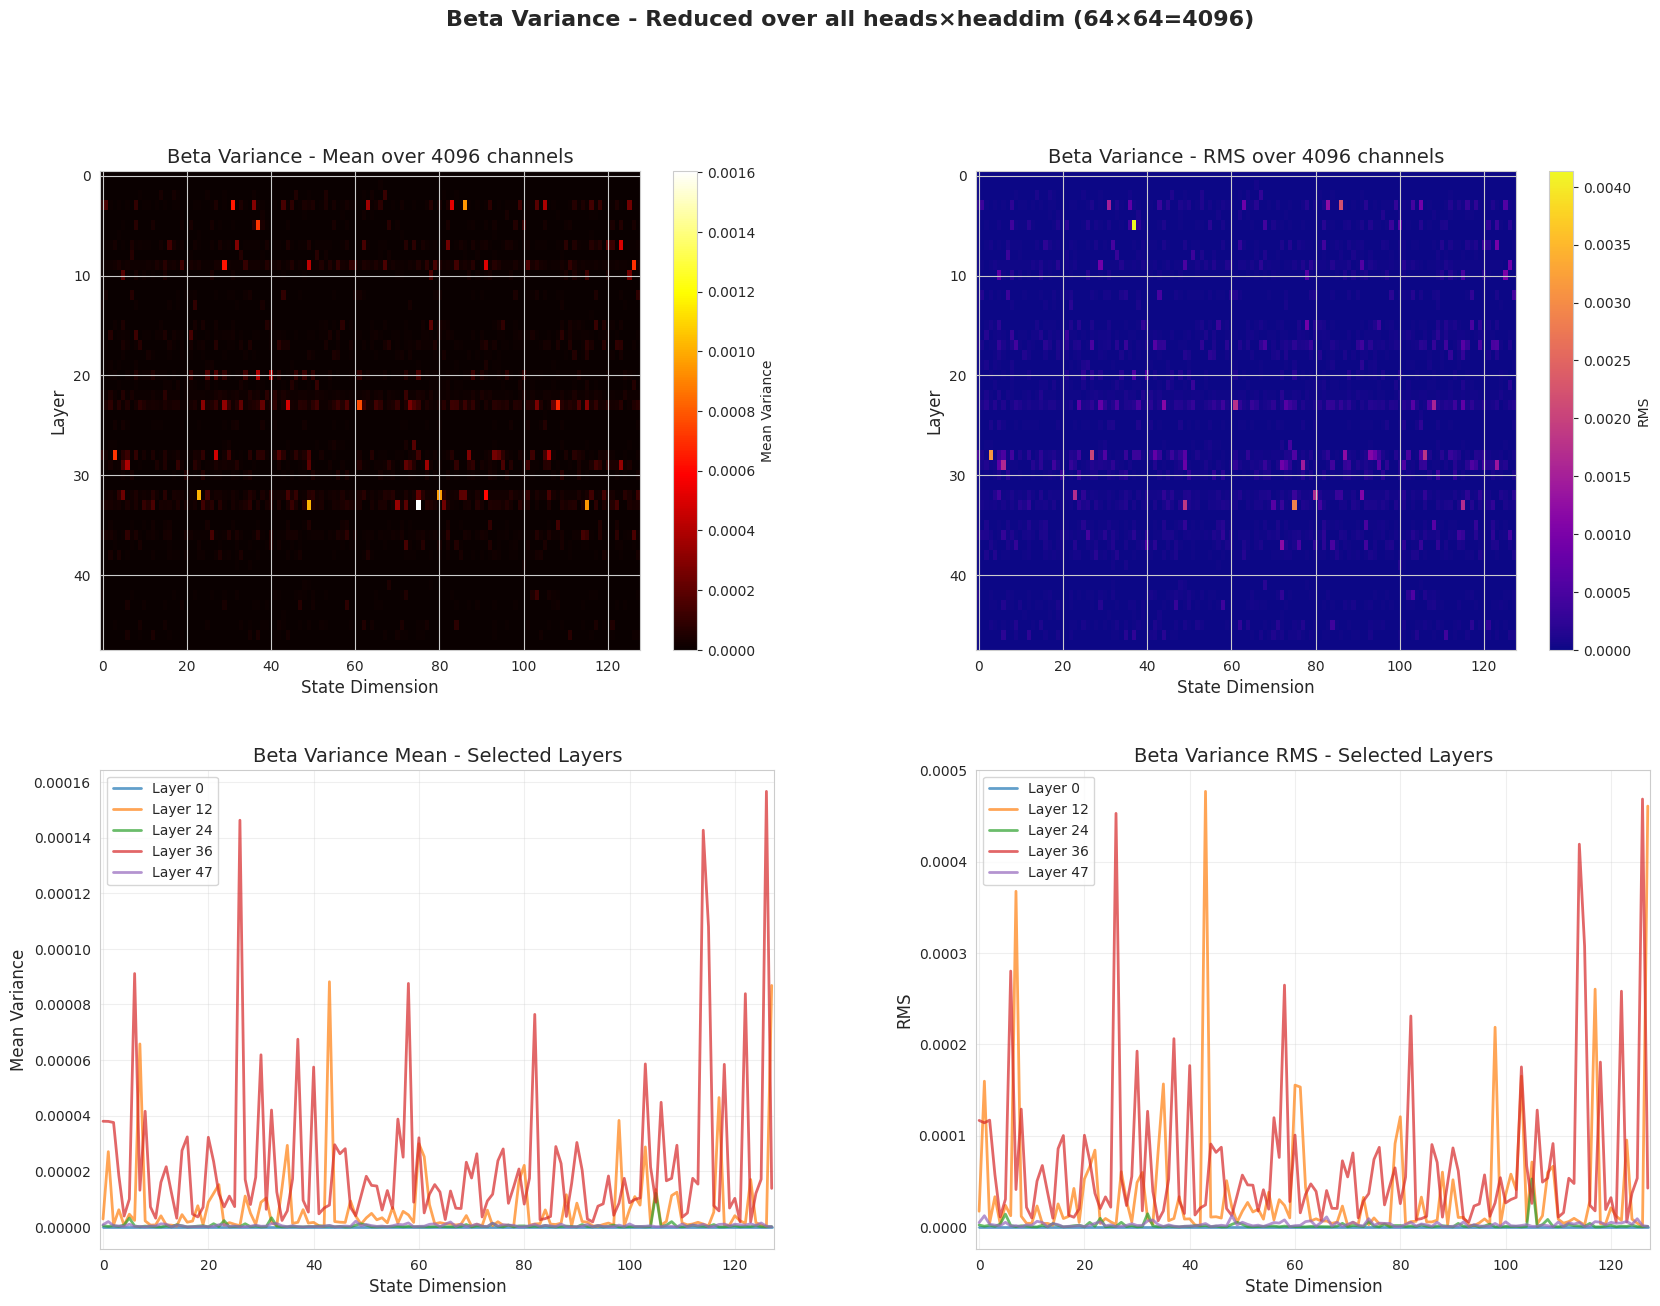

In [29]:
# Flatten last two dimensions (nheads * headdim) and reduce
# beta_var: [n_layer, nheads, headdim, d_state] -> [n_layer, nheads*headdim, d_state]
beta_var_flat = beta_var.reshape(n_layer, -1, d_state)  # [n_layer, nheads*headdim, d_state]

# Calculate mean and RMS over the flattened dimension
beta_var_flat_mean = beta_var_flat.mean(dim=1).cpu().numpy()  # [n_layer, d_state]
beta_var_flat_rms = torch.sqrt((beta_var_flat ** 2).mean(dim=1)).cpu().numpy()  # [n_layer, d_state]

print(f"Beta variance flat shape: {beta_var_flat.shape}")
print(f"Beta variance flat mean shape: {beta_var_flat_mean.shape}")
print(f"Beta variance flat RMS shape: {beta_var_flat_rms.shape}")

# Use selected_layers from Section 2 (reuse if already defined, otherwise define)
if 'selected_layers' not in locals():
    selected_layers = [0, n_layer//4, n_layer//2, 3*n_layer//4, n_layer-1]

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14),
                         gridspec_kw={'hspace': 0.25, 'wspace': 0.3})

# Share x-axis between rows
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 1])

# Add main title
fig.suptitle(f"Beta Variance - Reduced over all heads×headdim ({nheads}×{headdim}={nheads*headdim})", 
             fontsize=16, fontweight='bold', y=0.995)

# Top Left: Mean Heatmap
im1 = axes[0, 0].imshow(beta_var_flat_mean, aspect='auto', cmap='hot', interpolation='nearest')
axes[0, 0].set_ylabel('Layer', fontsize=12)
axes[0, 0].set_xlabel('State Dimension', fontsize=12)
axes[0, 0].set_title(f'Beta Variance - Mean over {nheads*headdim} channels', fontsize=14)
plt.colorbar(im1, ax=axes[0, 0], label='Mean Variance')

# Top Right: RMS Heatmap
im2 = axes[0, 1].imshow(beta_var_flat_rms, aspect='auto', cmap='plasma', interpolation='nearest')
axes[0, 1].set_ylabel('Layer', fontsize=12)
axes[0, 1].set_xlabel('State Dimension', fontsize=12)
axes[0, 1].set_title(f'Beta Variance - RMS over {nheads*headdim} channels', fontsize=14)
plt.colorbar(im2, ax=axes[0, 1], label='RMS')

# Bottom Left: Line plot for Mean
for layer in selected_layers:
    axes[1, 0].plot(beta_var_flat_mean[layer], label=f'Layer {layer}', alpha=0.7, linewidth=2)
axes[1, 0].set_xlabel('State Dimension', fontsize=12)
axes[1, 0].set_ylabel('Mean Variance', fontsize=12)
axes[1, 0].set_title('Beta Variance Mean - Selected Layers', fontsize=14)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Bottom Right: Line plot for RMS
for layer in selected_layers:
    axes[1, 1].plot(beta_var_flat_rms[layer], label=f'Layer {layer}', alpha=0.7, linewidth=2)
axes[1, 1].set_xlabel('State Dimension', fontsize=12)
axes[1, 1].set_ylabel('RMS', fontsize=12)
axes[1, 1].set_title('Beta Variance RMS - Selected Layers', fontsize=14)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Beta variance heatmap mean shape: (48, 4096)
Beta variance heatmap RMS shape: (48, 4096)
Mean range: [0.000000e+00, 1.217636e-03]
RMS range: [0.000000e+00, 2.892377e-03]


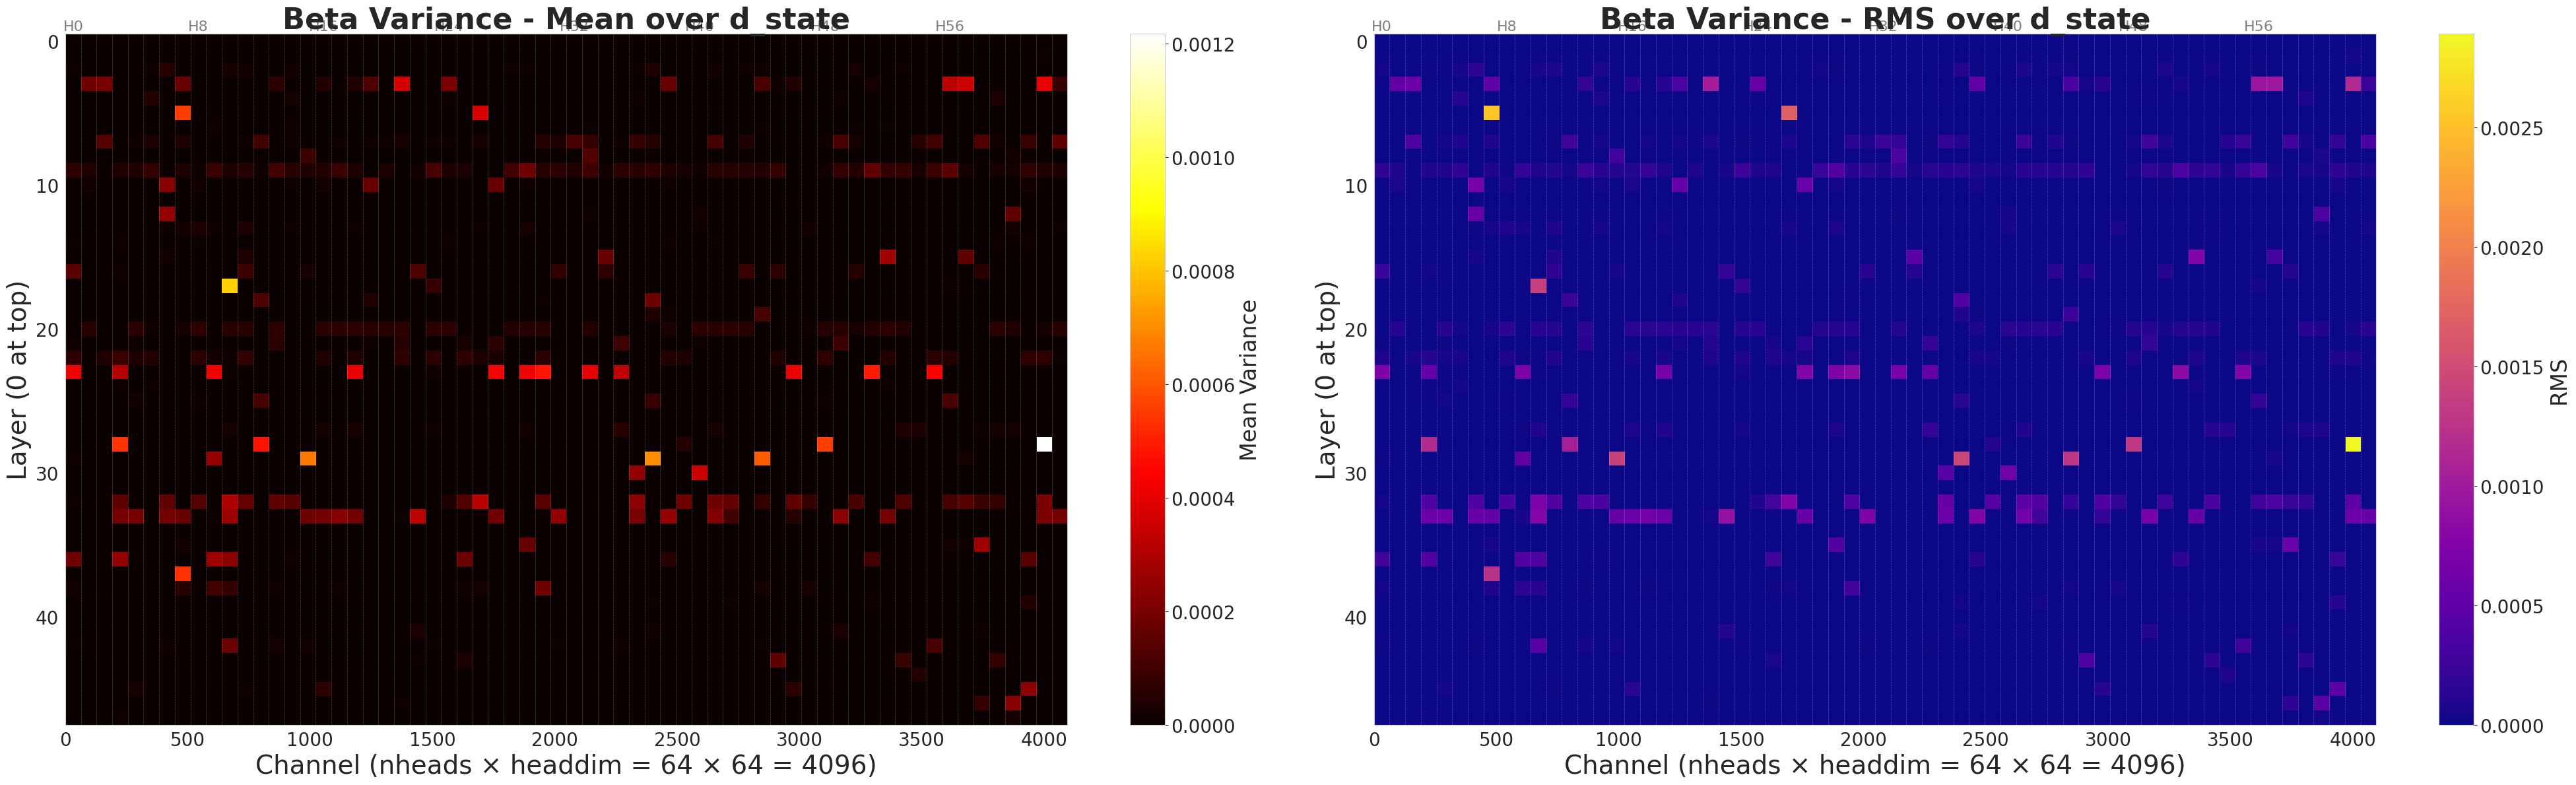

In [30]:
# Heatmap: reduce d_state dimension, 展开 nheads × headdim
# beta_var: [n_layer, nheads, headdim, d_state]

# Left: Mean over d_state -> [n_layer, nheads, headdim]
beta_var_reduced_state = beta_var.mean(dim=3).cpu().numpy()
beta_var_heatmap_mean = beta_var_reduced_state.reshape(n_layer, -1)  # [n_layer, nheads*headdim]

# Right: RMS over d_state -> [n_layer, nheads, headdim]
beta_var_rms_reduced_state = torch.sqrt((beta_var ** 2).mean(dim=3)).cpu().numpy()
beta_var_heatmap_rms = beta_var_rms_reduced_state.reshape(n_layer, -1)  # [n_layer, nheads*headdim]

print(f"Beta variance heatmap mean shape: {beta_var_heatmap_mean.shape}")
print(f"Beta variance heatmap RMS shape: {beta_var_heatmap_rms.shape}")
print(f"Mean range: [{beta_var_heatmap_mean.min():.6e}, {beta_var_heatmap_mean.max():.6e}]")
print(f"RMS range: [{beta_var_heatmap_rms.min():.6e}, {beta_var_heatmap_rms.max():.6e}]")

# Create figure with 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(40, 12))

# Left: Mean heatmap
im1 = axes[0].imshow(beta_var_heatmap_mean, aspect='auto', cmap='hot', interpolation='nearest')

axes[0].set_xlabel(f'Channel (nheads × headdim = {nheads} × {headdim} = {nheads*headdim})', fontsize=28)
axes[0].set_ylabel('Layer (0 at top)', fontsize=28)
axes[0].set_title('Beta Variance - Mean over d_state', fontsize=32, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=20)
axes[0].grid(False)

cbar1 = plt.colorbar(im1, ax=axes[0], label='Mean Variance')
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label('Mean Variance', fontsize=24)

# Add vertical lines to separate heads
for head_idx in range(1, nheads):
    axes[0].axvline(x=head_idx * headdim - 0.5, color='white', linestyle='--', alpha=0.3, linewidth=0.5)

# Add text annotation for head boundaries
head_stride = max(1, nheads // 8)
for head_idx in range(0, nheads, head_stride):
    x_pos = head_idx * headdim + headdim // 2
    axes[0].text(x_pos, -1.5, f'H{head_idx}', ha='center', va='top', fontsize=16, color='gray')

# Right: RMS heatmap
im2 = axes[1].imshow(beta_var_heatmap_rms, aspect='auto', cmap='plasma', interpolation='nearest')

axes[1].set_xlabel(f'Channel (nheads × headdim = {nheads} × {headdim} = {nheads*headdim})', fontsize=28)
axes[1].set_ylabel('Layer (0 at top)', fontsize=28)
axes[1].set_title('Beta Variance - RMS over d_state', fontsize=32, fontweight='bold')
axes[1].tick_params(axis='both', labelsize=20)
axes[1].grid(False)

cbar2 = plt.colorbar(im2, ax=axes[1], label='RMS')
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label('RMS', fontsize=24)

# Add vertical lines to separate heads
for head_idx in range(1, nheads):
    axes[1].axvline(x=head_idx * headdim - 0.5, color='white', linestyle='--', alpha=0.3, linewidth=0.5)

# Add text annotation for head boundaries
for head_idx in range(0, nheads, head_stride):
    x_pos = head_idx * headdim + headdim // 2
    axes[1].text(x_pos, -1.5, f'H{head_idx}', ha='center', va='top', fontsize=16, color='gray')

plt.tight_layout()
plt.show()


## 4. Visualize Beta CV (Coefficient of Variation) - Heatmaps

Visualize CV = std / mean for each point across layers, heads, and state dimensions.

Beta CV flat shape: torch.Size([48, 4096, 128])
Beta CV flat mean shape: (48, 128)
Beta CV flat RMS shape: (48, 128)


/root/autodl-tmp/tmp/ipykernel_191849/3669069656.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


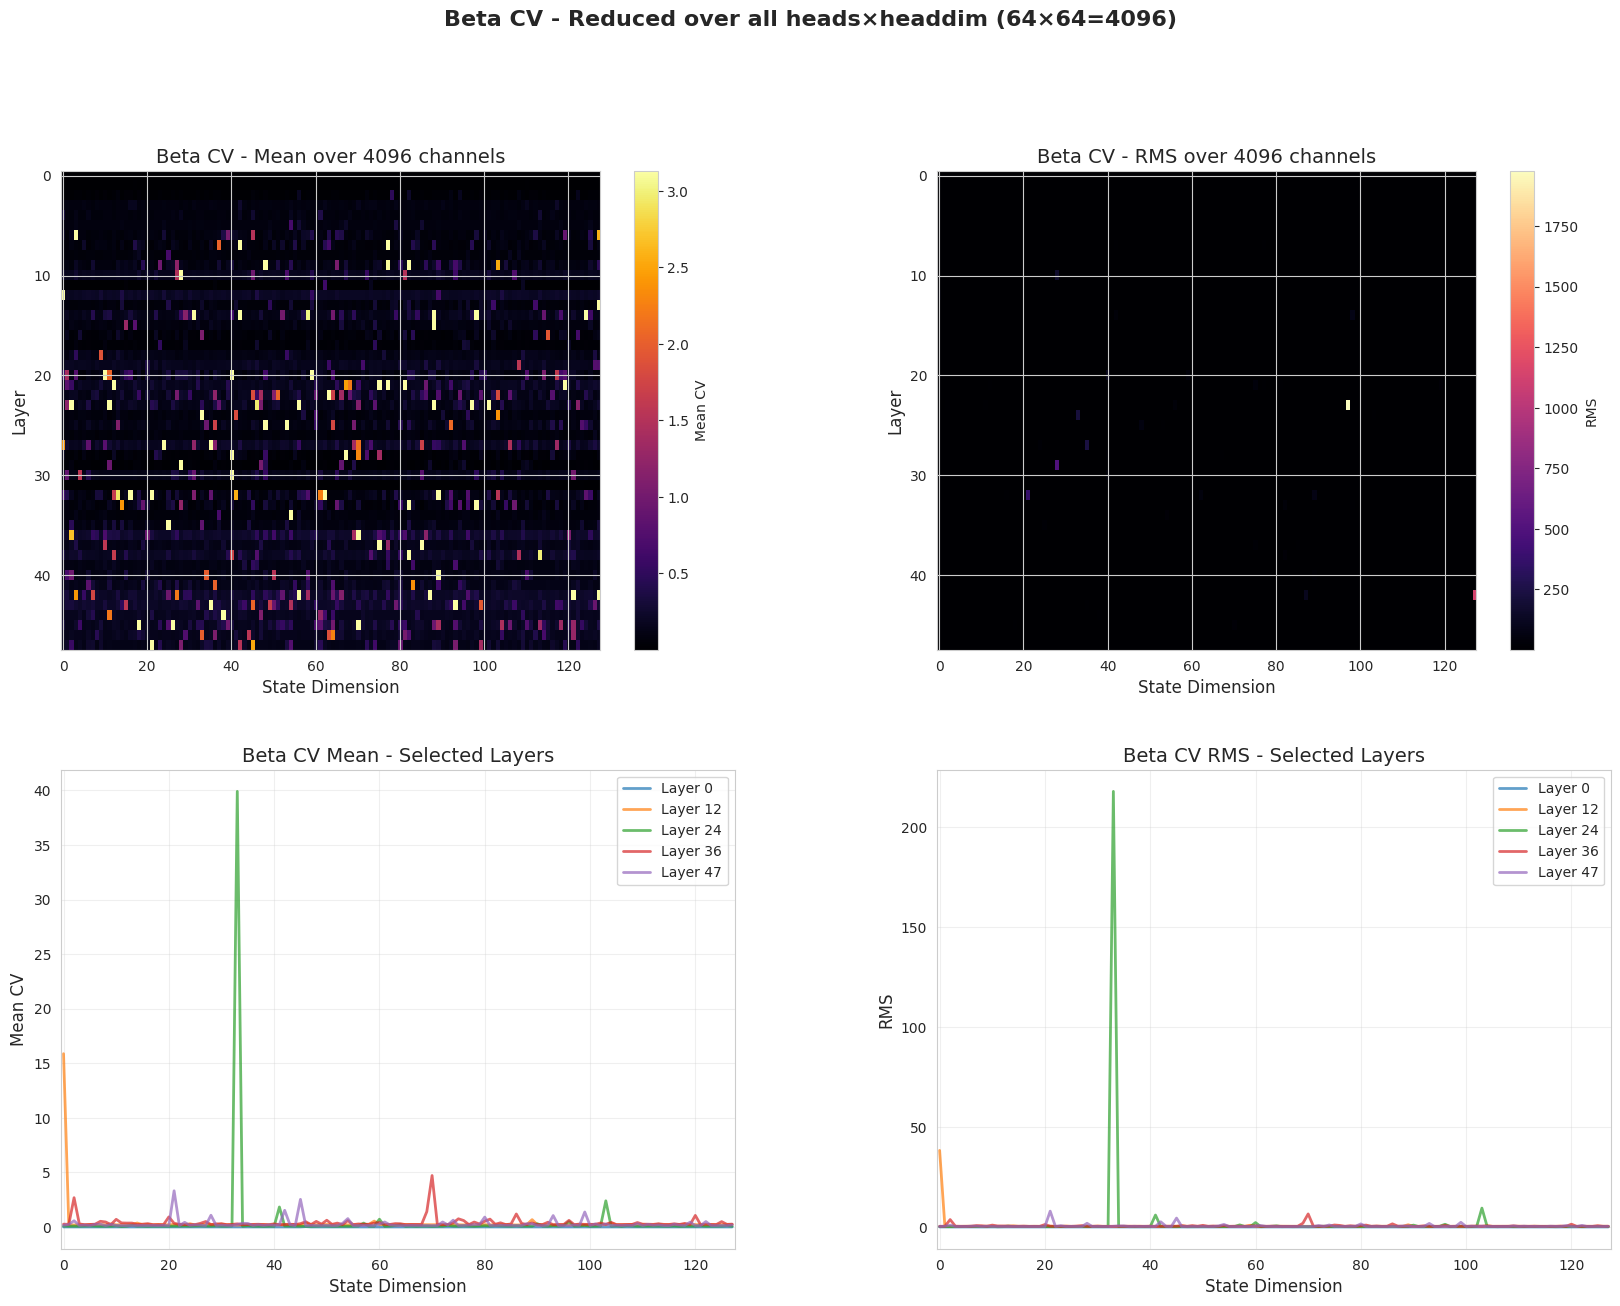

In [31]:
# Calculate coefficient of variation (CV) = std / |mean|
# CV measures relative variability, normalizing variance by the mean
# Add small epsilon to avoid division by zero
epsilon = 1e-8

# Calculate CV: std / |mean|
# beta_var: [n_layer, nheads, headdim, d_state]
# beta_mean: [n_layer, nheads, headdim, d_state]
beta_std = torch.sqrt(beta_var)
beta_cv = beta_std / (torch.abs(beta_mean) + epsilon)

# Flatten last two dimensions (nheads * headdim) and reduce
# beta_cv: [n_layer, nheads, headdim, d_state] -> [n_layer, nheads*headdim, d_state]
beta_cv_flat = beta_cv.reshape(n_layer, -1, d_state)  # [n_layer, nheads*headdim, d_state]

# Calculate mean and RMS over the flattened dimension
beta_cv_flat_mean = beta_cv_flat.mean(dim=1).cpu().numpy()  # [n_layer, d_state]
beta_cv_flat_rms = torch.sqrt((beta_cv_flat ** 2).mean(dim=1)).cpu().numpy()  # [n_layer, d_state]

print(f"Beta CV flat shape: {beta_cv_flat.shape}")
print(f"Beta CV flat mean shape: {beta_cv_flat_mean.shape}")
print(f"Beta CV flat RMS shape: {beta_cv_flat_rms.shape}")

# Use selected_layers from Section 2 (reuse if already defined, otherwise define)
if 'selected_layers' not in locals():
    selected_layers = [0, n_layer//4, n_layer//2, 3*n_layer//4, n_layer-1]

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14),
                         gridspec_kw={'hspace': 0.25, 'wspace': 0.3})

# Share x-axis between rows
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 1])

# Add main title
fig.suptitle(f"Beta CV - Reduced over all heads×headdim ({nheads}×{headdim}={nheads*headdim})", 
             fontsize=16, fontweight='bold', y=0.995)

# Top Left: Mean Heatmap (use percentile scaling)
vmin_cv_flat = np.percentile(beta_cv_flat_mean, 1)
vmax_cv_flat = np.percentile(beta_cv_flat_mean, 99)
im1 = axes[0, 0].imshow(beta_cv_flat_mean, aspect='auto', cmap='inferno', 
                        interpolation='nearest', vmin=vmin_cv_flat, vmax=vmax_cv_flat)
axes[0, 0].set_ylabel('Layer', fontsize=12)
axes[0, 0].set_xlabel('State Dimension', fontsize=12)
axes[0, 0].set_title(f'Beta CV - Mean over {nheads*headdim} channels', fontsize=14)
plt.colorbar(im1, ax=axes[0, 0], label='Mean CV')

# Top Right: RMS Heatmap
im2 = axes[0, 1].imshow(beta_cv_flat_rms, aspect='auto', cmap='magma', interpolation='nearest')
axes[0, 1].set_ylabel('Layer', fontsize=12)
axes[0, 1].set_xlabel('State Dimension', fontsize=12)
axes[0, 1].set_title(f'Beta CV - RMS over {nheads*headdim} channels', fontsize=14)
plt.colorbar(im2, ax=axes[0, 1], label='RMS')

# Bottom Left: Line plot for Mean
for layer in selected_layers:
    axes[1, 0].plot(beta_cv_flat_mean[layer], label=f'Layer {layer}', alpha=0.7, linewidth=2)
axes[1, 0].set_xlabel('State Dimension', fontsize=12)
axes[1, 0].set_ylabel('Mean CV', fontsize=12)
axes[1, 0].set_title('Beta CV Mean - Selected Layers', fontsize=14)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Bottom Right: Line plot for RMS
for layer in selected_layers:
    axes[1, 1].plot(beta_cv_flat_rms[layer], label=f'Layer {layer}', alpha=0.7, linewidth=2)
axes[1, 1].set_xlabel('State Dimension', fontsize=12)
axes[1, 1].set_ylabel('RMS', fontsize=12)
axes[1, 1].set_title('Beta CV RMS - Selected Layers', fontsize=14)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Beta CV heatmap mean shape: (48, 4096)
Beta CV heatmap RMS shape: (48, 4096)
Mean range: [0.000000e+00, 1.184076e+02]
RMS range: [0.000000e+00, 1.327011e+03]


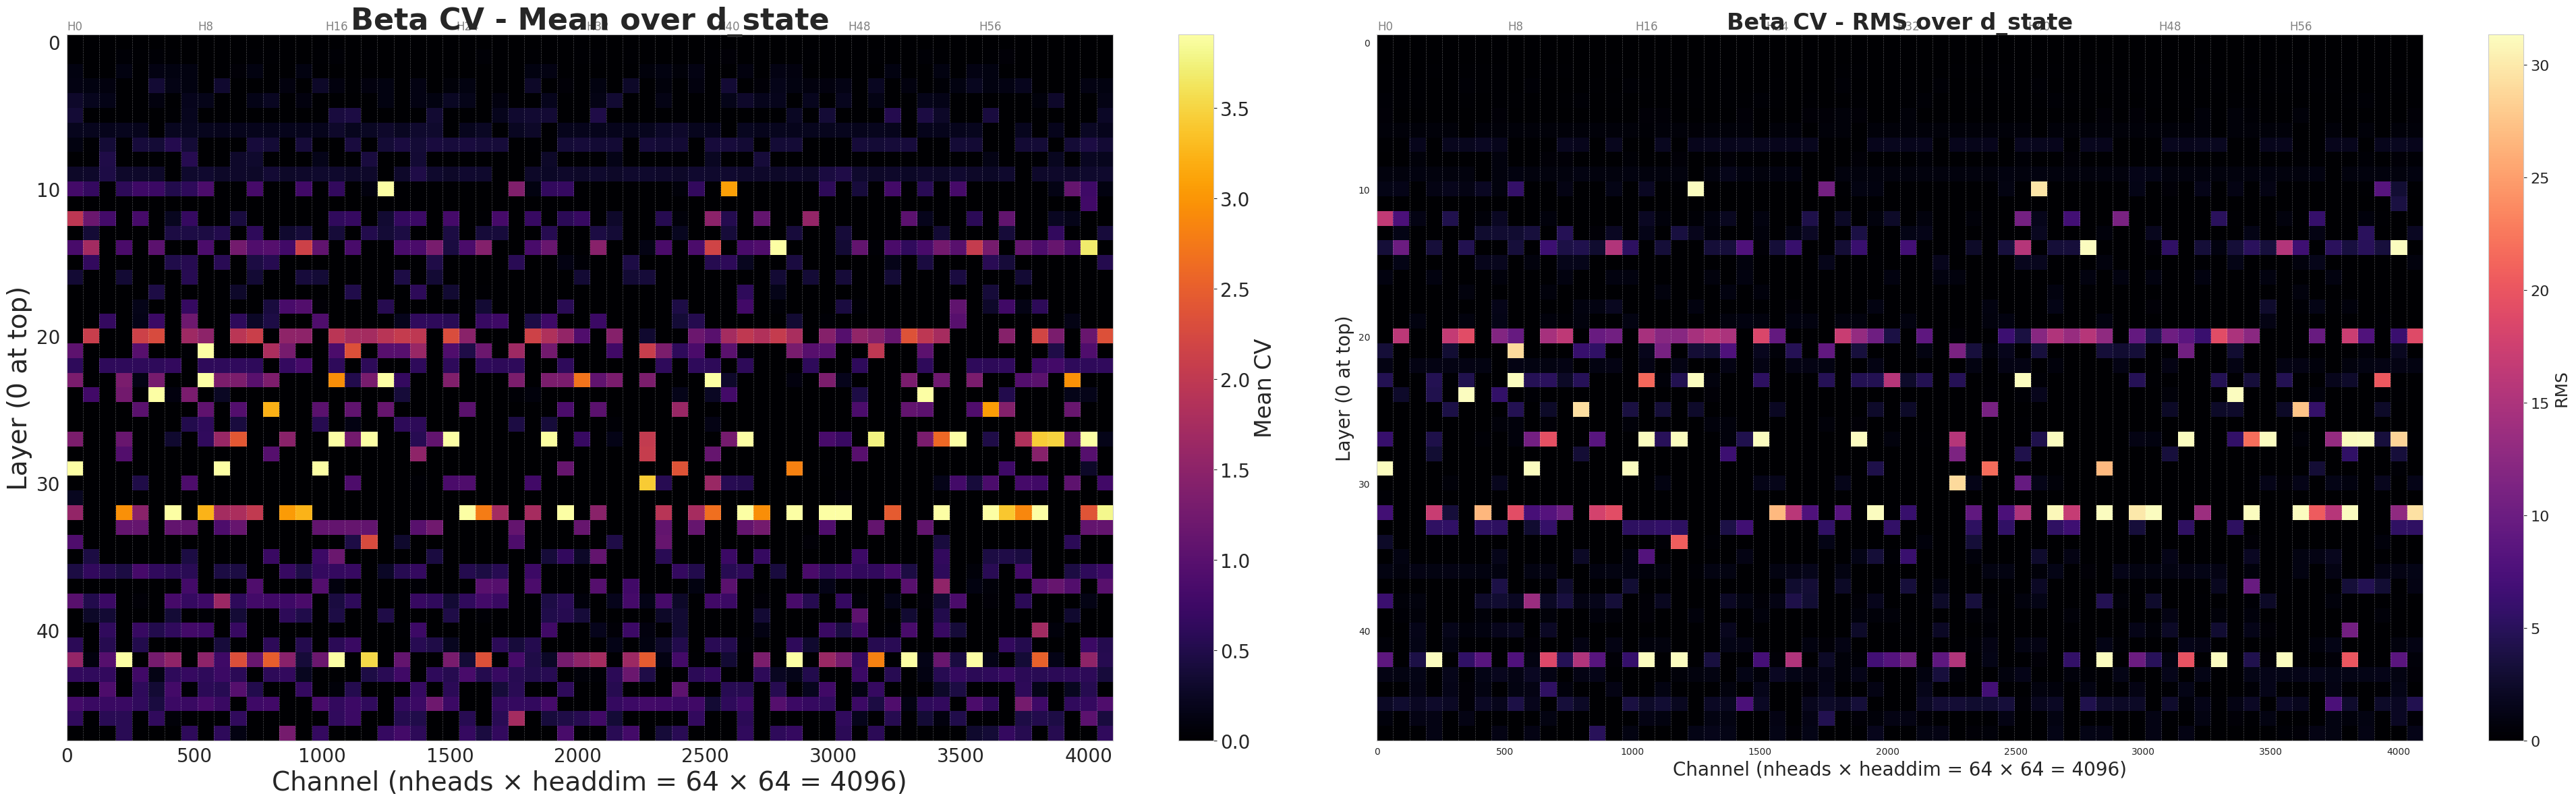

In [ ]:
# Heatmap: reduce d_state dimension, 展开 nheads × headdim
# beta_cv: [n_layer, nheads, headdim, d_state]

# Left: Mean over d_state -> [n_layer, nheads, headdim]
beta_cv_reduced_state = beta_cv.mean(dim=3).cpu().numpy()
beta_cv_heatmap_mean = beta_cv_reduced_state.reshape(n_layer, -1)  # [n_layer, nheads*headdim]

# Right: RMS over d_state -> [n_layer, nheads, headdim]
beta_cv_rms_reduced_state = torch.sqrt((beta_cv ** 2).mean(dim=3)).cpu().numpy()
beta_cv_heatmap_rms = beta_cv_rms_reduced_state.reshape(n_layer, -1)  # [n_layer, nheads*headdim]

print(f"Beta CV heatmap mean shape: {beta_cv_heatmap_mean.shape}")
print(f"Beta CV heatmap RMS shape: {beta_cv_heatmap_rms.shape}")
print(f"Mean range: [{beta_cv_heatmap_mean.min():.6e}, {beta_cv_heatmap_mean.max():.6e}]")
print(f"RMS range: [{beta_cv_heatmap_rms.min():.6e}, {beta_cv_heatmap_rms.max():.6e}]")

# Create figure with 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(40, 12))

# Left: Mean heatmap (use percentile scaling)
vmin_mean_hm = np.percentile(beta_cv_heatmap_mean, 1)
vmax_mean_hm = np.percentile(beta_cv_heatmap_mean, 99)

im1 = axes[0].imshow(beta_cv_heatmap_mean, aspect='auto', cmap='inferno', 
                     interpolation='nearest', vmin=vmin_mean_hm, vmax=vmax_mean_hm)

axes[0].set_xlabel(f'Channel (nheads × headdim = {nheads} × {headdim} = {nheads*headdim})', fontsize=28)
axes[0].set_ylabel('Layer (0 at top)', fontsize=28)
axes[0].set_title('Beta CV - Mean over d_state', fontsize=32, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=20)
axes[0].grid(False)

cbar1 = plt.colorbar(im1, ax=axes[0], label='Mean CV')
cbar1.ax.tick_params(labelsize=20)
cbar1.set_label('Mean CV', fontsize=24)

# Add vertical lines to separate heads
for head_idx in range(1, nheads):
    axes[0].axvline(x=head_idx * headdim - 0.5, color='white', linestyle='--', alpha=0.3, linewidth=0.5)

# Add text annotation for head boundaries
head_stride = max(1, nheads // 8)
for head_idx in range(0, nheads, head_stride):
    x_pos = head_idx * headdim + headdim // 2
    axes[0].text(x_pos, -1.5, f'H{head_idx}', ha='center', va='top', fontsize=12, color='gray')

# Right: RMS heatmap
vmin_rms_hm = np.percentile(beta_cv_heatmap_rms, 1)
vmax_rms_hm = np.percentile(beta_cv_heatmap_rms, 99)

im2 = axes[1].imshow(beta_cv_heatmap_rms, aspect='auto', cmap='magma', 
                     interpolation='nearest', vmin=vmin_rms_hm, vmax=vmax_rms_hm)

axes[1].set_xlabel(f'Channel (nheads × headdim = {nheads} × {headdim} = {nheads*headdim})', fontsize=20)
axes[1].set_ylabel('Layer (0 at top)', fontsize=20)
axes[1].set_title('Beta CV - RMS over d_state', fontsize=24, fontweight='bold')
axes[1].grid(False)

cbar2 = plt.colorbar(im2, ax=axes[1], label='RMS')
cbar2.ax.tick_params(labelsize=16)
cbar2.set_label('RMS', fontsize=18)

# Add vertical lines to separate heads
for head_idx in range(1, nheads):
    axes[1].axvline(x=head_idx * headdim - 0.5, color='white', linestyle='--', alpha=0.3, linewidth=0.5)

# Add text annotation for head boundaries
for head_idx in range(0, nheads, head_stride):
    x_pos = head_idx * headdim + headdim // 2
    axes[1].text(x_pos, -1.5, f'H{head_idx}', ha='center', va='top', fontsize=12, color='gray')



plt.tight_layout()
plt.show()